In [1592]:
#We're in EXERCISE 3

In [1593]:
'''pip install pandas
pip install matplotlib
pip install numpy'''

'pip install pandas\npip install matplotlib\npip install numpy'

In [1594]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.optimize as sco

# Import datatsets

In [1595]:
#Monthly RI and capitalization of EUR firms
df_EUR_M_cap=pd.read_csv('https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/ex_2/df_EUR_monthly_capitalization.csv')
df_EUR_M_RI=pd.read_csv('https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/ex_2/df_EUR_monthly_RI.csv')
#Yearly RI and capitalization of EUR firms
df_EUR_Y_cap=pd.read_csv('https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/baltha/df_EUR_yearly_capitalization.csv')
df_EUR_Y_RI=pd.read_csv('https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/baltha/df_EUR_yearly_return.csv')
#Yearly E score 
df_E_score=pd.read_csv('https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/baltha/DS_EScore_Y.csv')

# Question 3

### Create the dataset 

In [1596]:
#Create a new column with only the 2 first caracters of the column ISIN

df_E_score['ISIN_First2'] = df_E_score['ISIN'].str[:2]

In [1597]:
#df_E_score

In [1598]:
#Compute the monthly returns of EUR firms
df_EUR_M_RI.set_index('NAME', inplace = True)

df_EUR_M_RI.drop(df_EUR_M_RI.columns[:4], axis=1, inplace=True)

df_EUR_M_RI.columns = pd.to_datetime(df_EUR_M_RI.columns)

#df_EUR_M_RI_08 = df_EUR_M_RI.loc[:, (df_EUR_M_RI.columns >= pd.to_datetime("2007-01-01"))]
df_EUR_M_RI_08 = df_EUR_M_RI.loc[:, ((df_EUR_M_RI.columns >= pd.to_datetime("2007-01-01")) & (df_EUR_M_RI.columns <= ("2021-12-31")))]

df_EUR_M_RI_T = df_EUR_M_RI_08.T

df_M_returns = df_EUR_M_RI_T.pct_change()

#df_M_returns

In [1599]:
#Extract the list of firms that have an Environmental score
firms_list = df_E_score['NAME'].tolist()
#firms_list

In [1600]:
#Get monthly returns of EUR firms with an Environmental score
df_M_returns_E = df_M_returns[df_M_returns.columns.intersection(firms_list)]
#df_M_returns_E


In [1601]:
#Drop the row 2007-01-31 because it has only NaN values
df_M_returns_E = df_M_returns_E.drop('2007-01-31')
#df_M_returns_E

### Average/expected return

In [1642]:
#Compute the average (or expected) returns
avrg_returns = df_M_returns_E.mean()
#avrg_returns

-0.03457573200227787

In [1603]:
#The company PROFASE probably dropped out of the market; the change in returns would be infinite, we set it to 0
avrg_returns[avrg_returns == np.inf] = 0 

### Covariance matrix

In [1604]:
#Compute the covariance matrix
cov_matrix = df_M_returns_E.cov()
#cov_matrix

### Minimum variance portfolio (MVP)

In [1605]:
#Taking the number of assets
numAssets = len(avrg_returns)

#Function to compute the variance
def min_var(weights):
    weights = np.array(weights)
    var = np.dot(weights.T, np.dot(cov_matrix * 12, weights))
    return var

#Initial conditions: initial weights -> EW and each weight >= 0
initialWeights = np.ones(numAssets)/numAssets
positivity_bounds = tuple((0, 1) for x in range(numAssets))

#Constraint: sum of weights = 1
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

#Optimize minimum variance portfolio
result_long_only_gmv_portfolio = sco.minimize(min_var, initialWeights, method='SLSQP', bounds=positivity_bounds, constraints=cons)
result_long_only_gmv_portfolio

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.011782738488221834
       x: [ 5.627e-17  9.157e-17 ...  1.209e-17  0.000e+00]
     nit: 16
     jac: [ 4.012e-02  5.912e-02 ...  4.906e-02  4.315e-02]
    nfev: 6784
    njev: 16

In [1606]:
#Compute the minimum variance portfolio
avrg_returns_MVP = np.dot(result_long_only_gmv_portfolio['x'], avrg_returns)
avrg_returns_MVP

0.008174273336268282

In [1607]:
#Compute the annualized MVP
avrg_returns_MVP_ann = avrg_returns_MVP * 12
avrg_returns_MVP_ann

0.09809128003521939

### Maximum return portfolio

In [1608]:
#Function to compute the returns
def max_return(weights):
    weighted_returns = -np.dot(weights, avrg_returns * 12)
    return weighted_returns

#Constraints (same as for the MVP portfolio)
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}, {'type': 'ineq', 'fun': lambda x: x})
positivity_bounds = tuple((0, 1) for x in range(numAssets))
initialWeights = np.ones(numAssets)/numAssets

#Optimize maximum return portfolio
result_max_return_portfolio = sco.minimize(max_return, initialWeights, method='SLSQP', bounds=positivity_bounds, constraints=cons)
result_max_return_portfolio

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.3285704930020861
       x: [ 1.663e-15  0.000e+00 ...  0.000e+00  1.132e-16]
     nit: 9
     jac: [-9.430e-02 -1.035e-01 ... -7.079e-02 -1.834e-01]
    nfev: 3816
    njev: 9

In [1609]:
#Check the weights of the maximum return portfolio
#result_max_return_portfolio['x']

In [1610]:
#Compute the maximum return portfolio
avrg_returns_MaxRP = np.dot(result_max_return_portfolio['x'], avrg_returns)
avrg_returns_MaxRP

0.027380874416840503

In [1611]:
#Compute the annualized maximum return portfolio
avrg_returns_MaxRP_ann = avrg_returns_MaxRP * 12
avrg_returns_MaxRP_ann

0.328570493002086

### Minimum return portfolio

In [1612]:
#Function to compute the returns
def min_return(weights):
    weight_returns = np.dot(weights, avrg_returns * 12)
    return weight_returns

#Constraints
numAssets = len(avrg_returns)
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
positivity_bounds = tuple((0, 1) for x in range(numAssets))
initialWeights = np.array(numAssets*[1/numAssets])

#Optimize minimum return portfolio
result_min_return_portfolio = sco.minimize(min_return, initialWeights, method='SLSQP', bounds= positivity_bounds, constraints=cons)
result_min_return_portfolio

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.4149087840273254
       x: [ 9.771e-16  0.000e+00 ...  0.000e+00  2.140e-16]
     nit: 6
     jac: [ 9.430e-02  1.035e-01 ...  7.079e-02  1.834e-01]
    nfev: 2544
    njev: 6

In [1613]:
#Compute the minimum return portfolio
avrg_returns_MinRP = np.dot(result_min_return_portfolio['x'], avrg_returns)
avrg_returns_MinRP

-0.03457573200227714

In [1614]:
#Compute the annualized minimum return portfolio
avrg_returns_MinRP_ann = avrg_returns_MinRP * 12
avrg_returns_MinRP_ann

-0.41490878402732567

### Efficient frontier

In [1615]:
#Upper part of the efficient frontier

#Generate an array of evenly spaced target returns between the average return of the MVP and the average return of the max return portfolio
target_returns = np.linspace(avrg_returns_MVP, avrg_returns_MaxRP, 25)

#Initialize an empty list to store all the efficient portfolios to build the efficient frontier, and another for the portfolio weights
efficient_frontier_high = []
portfolio_weights = []

#Define portfolio volatility
def portfolio_volatility(weights):
    return np.sqrt(weights.T @ cov_matrix @ weights)

#Define the return constraint
def return_constraint(weights):
    return (weights @ avrg_returns) - target_return

#Constraints: sum of weights equals 1, portfolio weights * average returns = target return
for target_return in target_returns:
    cons = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': return_constraint})
    
#Run the optimization
    result = sco.minimize(portfolio_volatility, initialWeights, method='SLSQP', bounds=positivity_bounds, constraints=cons)

#Check if optimizer found a solution, if yes add the result (volatility, return)
    if result.success:
        efficient_frontier_high.append((result.fun, target_return))
        portfolio_weights.append(result.x)

#Put the results into a dataframe: it will contain the returns and their minimized volatility
df_frontier_high = pd.DataFrame(efficient_frontier_high, columns=['Volatility', 'Return'])
df_weights_high = pd.DataFrame(portfolio_weights)

In [1616]:
#Lower part of the efficient frontier

#Generate an array of evenly spaced target returns between the average return of the MVP and the average return of the max return portfolio
target_returns = np.linspace(avrg_returns_MVP, avrg_returns_MinRP, 25)

#Initialize an empty list to store all the efficient portfolios to build the efficient frontier, and another for the portfolio weights
efficient_frontier_low = []
portfolio_weights = []

#Define portfolio volatility
def portfolio_volatility(weights):
    return np.sqrt(weights.T @ cov_matrix @ weights)

#Define the return constraint
def return_constraint(weights):
    return (weights @ avrg_returns) - target_return

#Constraints: sum of weights equals 1, portfolio weights * average returns = target return
for target_return in target_returns:
    cons = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': return_constraint})
    
#Run the optimization
    result = sco.minimize(portfolio_volatility, initialWeights, method='SLSQP', bounds=positivity_bounds, constraints=cons)

#Check if optimizer found a solution, if yes add the result (volatility, return)
    if result.success:
        efficient_frontier_low.append((result.fun, target_return))
        portfolio_weights.append(result.x)

#Put the results into a dataframe: it will contain the returns and their minimized volatility
df_frontier_low = pd.DataFrame(efficient_frontier_low, columns=['Volatility', 'Return'])
df_weights_low = pd.DataFrame(portfolio_weights)

In [1617]:
#Concatenate the upper part and lower part of the efficient frontier, same for the weights
df_frontier = pd.concat([df_frontier_high, df_frontier_low]).reset_index(drop=True)
df_weights = pd.concat([df_weights_high, df_weights_low]).reset_index(drop=True)

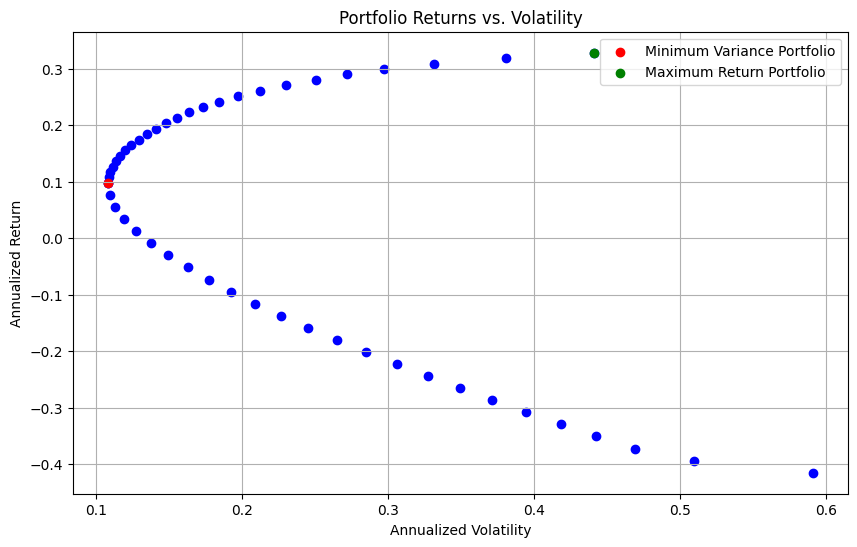

In [1618]:
#Annualize volatility and returns
df_frontier['Annualized Volatility'] = df_frontier['Volatility'] * np.sqrt(12)
df_frontier['Annualized Return'] = df_frontier['Return'] * 12

#Take the index of the MVP and MaxRP
MVP_index = df_frontier['Annualized Volatility'].idxmin()
MaxRP_index = df_frontier['Annualized Return'].idxmax()

#Initialize the figure
plt.figure(figsize=(10, 6))

#Plot the portfolios of the efficient frontier
plt.scatter(df_frontier['Annualized Volatility'], df_frontier['Annualized Return'], color='blue')

#Plot the MVP and the Max return portfolio (MaxRP)
plt.scatter(df_frontier.loc[MVP_index, 'Annualized Volatility'], df_frontier.loc[MVP_index, 'Annualized Return'], color='red', label='Minimum Variance Portfolio')
plt.scatter(df_frontier.loc[MaxRP_index, 'Annualized Volatility'], df_frontier.loc[MaxRP_index, 'Annualized Return'], color='green', label='Maximum Return Portfolio')

#Add title, legends, ect
plt.title('Portfolio Returns vs. Volatility')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

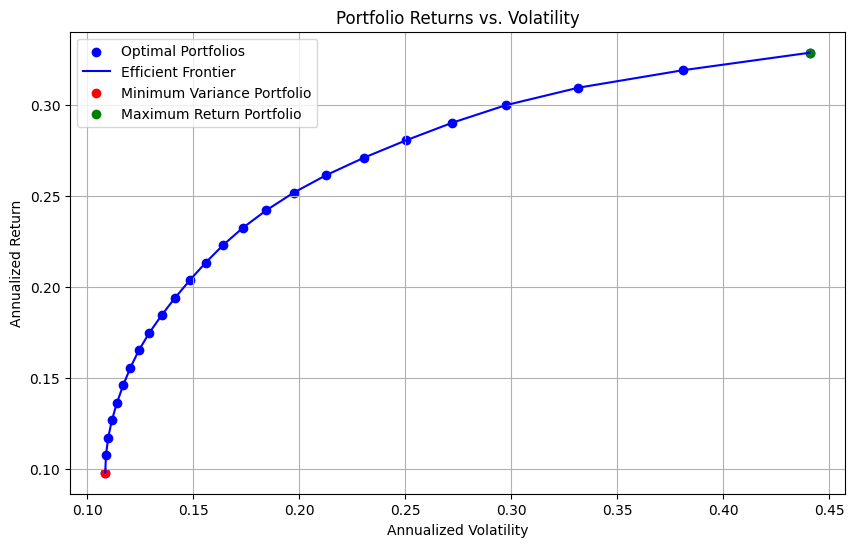

In [1619]:
#Keep only the upper part of the efficient frontier
#Annualize volatility and returns
df_frontier_high['Annualized Volatility'] = df_frontier_high['Volatility'] * np.sqrt(12)
df_frontier_high['Annualized Return'] = df_frontier_high['Return'] * 12

#Take the index of the MVP and MaxRP
MVP_index = df_frontier_high['Annualized Volatility'].idxmin()
MaxRP_index = df_frontier_high['Annualized Return'].idxmax()

#Initialize the figure
plt.figure(figsize=(10, 6))

#Plot the efficient frontier
plt.scatter(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Optimal Portfolios')
plt.plot(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Efficient Frontier')

#Plot the MVP and the Max return portfolio (MaxRP)
plt.scatter(df_frontier_high.loc[MVP_index, 'Annualized Volatility'], df_frontier_high.loc[MVP_index, 'Annualized Return'], color='red', label='Minimum Variance Portfolio')
plt.scatter(df_frontier_high.loc[MaxRP_index, 'Annualized Volatility'], df_frontier_high.loc[MaxRP_index, 'Annualized Return'], color='green', label='Maximum Return Portfolio')

#Add title, legends, ect
plt.title('Portfolio Returns vs. Volatility')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

### Ex-ante

In [1620]:
#Create the risk-free rate
rf = pd.read_csv('https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/FINAL/risk_free_rate_OECD.csv')
rf.head()

#Get the risk-free rate
rfr = rf.OBS_VALUE
rfr21 = rfr[:-1]

#Average annual risk free rate across all european countries over the 2000-2021 period
rfr_expected = rfr21.mean()/100

In [1621]:
rfr_expected

0.029896900272727275

In [1622]:
#Compute the sharpe ratio for each portfolio on the efficient frontier
df_frontier_high['Sharpe Ratio'] = (df_frontier_high['Annualized Return'] - rfr_expected) / df_frontier_high['Annualized Volatility']

#Find the portfolio with the maximum sharpe ratio
max_sharpe_index = df_frontier_high['Sharpe Ratio'].idxmax()
max_sharpe_portfolio = df_frontier_high.loc[max_sharpe_index]
print(max_sharpe_portfolio)

Volatility               0.044996
Return                   0.017778
Annualized Volatility    0.155869
Annualized Return        0.213331
Sharpe Ratio             1.176847
Name: 12, dtype: float64


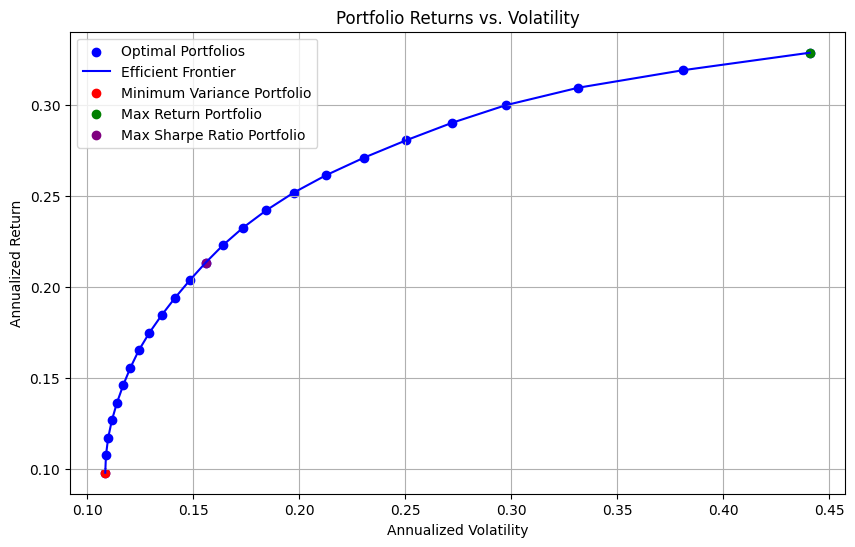

In [1623]:
#Initialize the figure
plt.figure(figsize=(10, 6))

#Plot the efficient frontier
plt.scatter(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Optimal Portfolios')
plt.plot(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Efficient Frontier')

#Plot the MVP, the MaxRP, and the Max Sharpe Ratio Portfolio
plt.scatter(df_frontier_high.loc[MVP_index, 'Annualized Volatility'], df_frontier_high.loc[MVP_index, 'Annualized Return'], color='red', label='Minimum Variance Portfolio')
plt.scatter(df_frontier_high.loc[MaxRP_index, 'Annualized Volatility'], df_frontier_high.loc[MaxRP_index, 'Annualized Return'], color='green', label='Max Return Portfolio')
plt.scatter(df_frontier_high.loc[max_sharpe_index, 'Annualized Volatility'], df_frontier_high.loc[max_sharpe_index, 'Annualized Return'], color='purple', label='Max Sharpe Ratio Portfolio')

#Add title, legends, ect
plt.title('Portfolio Returns vs. Volatility')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

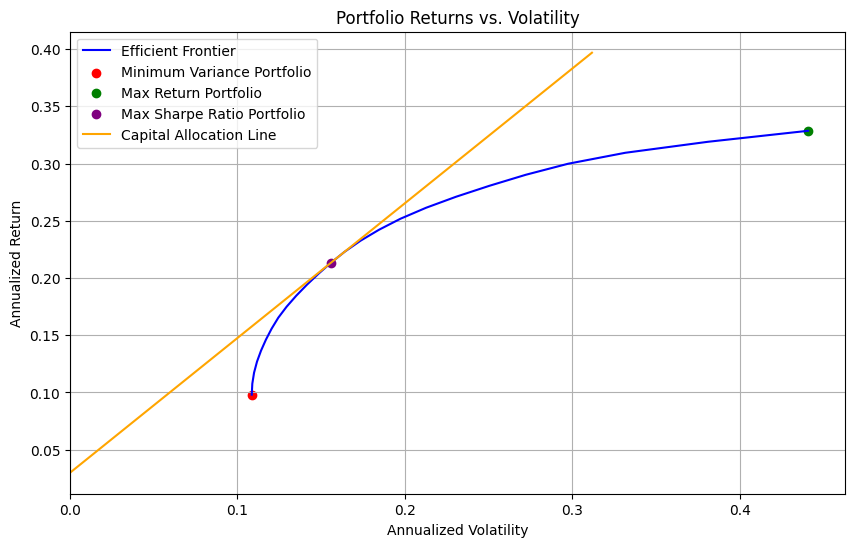

In [1624]:
#Initialize the figure
plt.figure(figsize=(10, 6))

#Get the volatility and the return of the maximum sharpe ratio portfolio
max_sharpe_volatility = df_frontier_high.loc[max_sharpe_index, 'Annualized Volatility']
max_sharpe_return = df_frontier_high.loc[max_sharpe_index, 'Annualized Return']

#Excess return of the Max Sharpe Ratio portfolio over the risk-free rate
max_sharpe_excess_return = max_sharpe_return - rfr_expected

#Get the slope of the capital allocation line (CAL), and the boundaries
CAL_slope = max_sharpe_excess_return / max_sharpe_volatility
CAL_x = max_sharpe_volatility * 2
CAL_y = rfr_expected + (CAL_x * (max_sharpe_return - rfr_expected) / max_sharpe_volatility)

#Plot the efficient frontier
#plt.scatter(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Optimal Portfolios')
plt.plot(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Efficient Frontier')

#Plot the MVP, the MaxRP, and the Max Sharpe Ratio Portfolio
plt.scatter(df_frontier_high.loc[MVP_index, 'Annualized Volatility'], df_frontier_high.loc[MVP_index, 'Annualized Return'], color='red', label='Minimum Variance Portfolio')
plt.scatter(df_frontier_high.loc[MaxRP_index, 'Annualized Volatility'], df_frontier_high.loc[MaxRP_index, 'Annualized Return'], color='green', label='Max Return Portfolio')
plt.scatter(df_frontier_high.loc[max_sharpe_index, 'Annualized Volatility'], df_frontier_high.loc[max_sharpe_index, 'Annualized Return'], color='purple', label='Max Sharpe Ratio Portfolio')

#Plot the capital allocation line (CAL)
plt.plot([0, CAL_x], [rfr_expected, CAL_y], color='orange', label='Capital Allocation Line')

#Add title, legends, ect
plt.xlim(0)
plt.title('Portfolio Returns vs. Volatility')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

In [1625]:
df_frontier_high

,Volatility,Return,Annualized Volatility,Annualized Return,Sharpe Ratio
0,0.031335,0.008174,0.108548,0.098091,0.628239
1,0.031431,0.008975,0.108881,0.107695,0.714519
2,0.031734,0.009775,0.109929,0.117298,0.795069
3,0.032238,0.010575,0.111676,0.126901,0.868623
4,0.032930,0.011375,0.114074,0.136504,0.934549
5,0.033775,0.012176,0.117000,0.146108,0.993258
6,0.034757,0.012976,0.120403,0.155711,1.044943
7,0.035911,0.013776,0.124398,0.165314,1.088582
8,0.037346,0.014576,0.129370,0.174918,1.120973
9,0.039009,0.015377,0.135129,0.184521,1.144266


### Ex-post

We take the year 2022 as ex-post period.

In [1626]:
#Compute the returns for EUR firms with an Env score for the year 2022
df_EUR_M_RI.columns = pd.to_datetime(df_EUR_M_RI.columns)

df_EUR_M_RI_22 = df_EUR_M_RI.loc[:, ((df_EUR_M_RI.columns >= pd.to_datetime("2021-12-31")) & (df_EUR_M_RI.columns <= ("2022-12-31")))]

df_EUR_M_RI_T = df_EUR_M_RI_22.T

df_M_returns_22 = df_EUR_M_RI_T.pct_change()

df_M_returns_22_E = df_M_returns_22[df_M_returns_22.columns.intersection(firms_list)]

df_M_returns_22_E = df_M_returns_22_E.drop('2021-12-31')

#Checking if there are inf or NaN values
has_inf = df_M_returns_22_E.isin([float('inf'), float('-inf')]).any().any()
#We find that the company 'PROSAFE' has some
df_M_returns_22_E['PROSAFE']
#Set the inf and NaN values to 0
df_M_returns_22_E.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

#df_M_returns_22_E

In [1639]:
df_M_returns_22_E

NAME,FLUGHAFEN WIEN,ERSTE GROUP BANK,OMV,VERBUND,WIENERBERGER,VIENNA INSURANCE GROUP A,VOESTALPINE,MAYR-MELNHOF KARTON,IMMOFINANZ,SOLVAY,...,HOLMEN B,FABEGE,KINNEVIK B,INVESTOR A,SWEDISH MATCH DEAD - DELIST.02/01/23,HEXAGON B,ELECTROLUX B,ATLAS COPCO A,MODERN TIMES GROUP MTG B,BOLIDEN ORD SHS
2022-01-31,0.045070,-0.017086,0.064909,-0.065063,-0.025202,0.027346,-0.093706,-0.038791,0.006766,0.037394,...,0.000546,-0.115790,-0.172933,-0.145478,-0.032722,-0.161358,-0.154198,-0.158052,0.299695,0.035070
2022-02-28,-0.005181,-0.222612,-0.213086,0.153609,-0.160986,-0.096533,0.002616,-0.019011,0.000145,-0.061855,...,0.031310,0.016525,-0.126390,-0.006801,-0.045179,0.025195,-0.117735,-0.099883,-0.021452,0.121249
2022-03-31,-0.071303,0.024673,0.014220,-0.124043,0.013548,-0.007269,-0.090822,-0.051694,-0.009392,-0.111310,...,0.167176,0.002185,0.031085,0.057366,0.035235,0.044213,-0.123966,0.007219,0.138457,0.143320
2022-04-30,-0.026577,-0.150132,0.072910,0.014660,-0.065702,-0.043776,-0.120637,-0.010740,-0.053461,-0.040202,...,0.034607,-0.180403,-0.249859,-0.105387,0.068660,-0.078859,0.005736,-0.118020,-0.276448,-0.120823
2022-05-31,-0.009072,0.046917,0.125019,-0.069705,-0.003308,0.014826,0.105362,-0.017804,-0.098783,0.039523,...,-0.125051,0.045561,-0.000300,-0.000506,0.284345,-0.065268,0.003241,-0.013003,0.099450,-0.008160
2022-06-30,0.215260,-0.185894,-0.159157,-0.016706,-0.222906,-0.050209,-0.274492,-0.008163,-0.305917,-0.171700,...,-0.209650,-0.257652,-0.192491,-0.139228,-0.014032,-0.146831,-0.132928,-0.165492,-0.101333,-0.241827
2022-07-31,-0.023149,-0.004502,-0.097421,0.123206,0.068705,0.002197,0.119471,-0.061965,0.007021,0.078548,...,0.007548,0.080770,0.109712,0.138937,0.024411,0.125264,0.065140,0.241231,0.282225,0.041119
2022-08-31,-0.010844,-0.102476,-0.040985,-0.125302,0.025707,0.041194,-0.093996,-0.056886,-0.023731,-0.069899,...,0.057246,-0.127134,-0.196640,-0.180800,-0.033070,-0.117770,-0.111130,-0.116587,-0.143647,-0.022490
2022-09-30,-0.021276,-0.018766,-0.096105,-0.106440,-0.140093,-0.139022,-0.152104,-0.136879,-0.178549,-0.037799,...,-0.113088,-0.220618,-0.072336,-0.075520,-0.015891,-0.083422,-0.143574,-0.076555,-0.243420,-0.033389
2022-10-31,0.007311,0.112197,0.259085,-0.085763,0.133224,0.093316,0.266377,0.100553,-0.034777,0.155775,...,-0.052283,0.060867,-0.071262,0.099971,0.037126,0.047419,0.177424,0.140971,0.123786,-0.068215


In [1627]:
#Concatenate the weights in each row (1 for each of the 25 portfolios) into a single cell and add the portfolio weights in the frontier dataframe
df_frontier_high['Weights'] = df_weights_high.apply(lambda row: np.array(row), axis=1)
df_frontier_high

,Volatility,Return,Annualized Volatility,Annualized Return,Sharpe Ratio,Weights
0,0.031335,0.008174,0.108548,0.098091,0.628239,"[9.219993655987922e-17, 1.2596559479041022e-16..."
1,0.031431,0.008975,0.108881,0.107695,0.714519,"[1.4842172155244773e-17, 0.0, 0.0, 0.0, 2.8121..."
2,0.031734,0.009775,0.109929,0.117298,0.795069,"[8.05586949193658e-17, 1.344844407892845e-16, ..."
3,0.032238,0.010575,0.111676,0.126901,0.868623,"[0.0, 0.0, 2.220272115436163e-17, 1.0684536510..."
4,0.032930,0.011375,0.114074,0.136504,0.934549,"[0.0, 5.600516394136353e-17, 0.0, 1.0055281274..."
5,0.033775,0.012176,0.117000,0.146108,0.993258,"[1.1137656365828134e-16, 7.921672830003791e-17..."
6,0.034757,0.012976,0.120403,0.155711,1.044943,"[1.811813145491148e-18, 9.931235987890345e-17,..."
7,0.035911,0.013776,0.124398,0.165314,1.088582,"[0.0, 3.9693017643695436e-17, 9.23261421945106..."
8,0.037346,0.014576,0.129370,0.174918,1.120973,"[0.0, 0.0, 5.4673372108792296e-17, 0.0, 7.3179..."
9,0.039009,0.015377,0.135129,0.184521,1.144266,"[5.679506477945294e-17, 2.9007229316973926e-17..."


In [1628]:
#Compute the monthly returns of 25 portfolios on the efficient frontier for 2022
M_portfolio_returns_22 = np.dot(df_weights_high, df_M_returns_22_E.T)
M_portfolio_returns_22.shape()

array([[-3.92538587e-02,  4.45150180e-02,  2.49027934e-02,
        -3.07571320e-02, -3.13573040e-02, -5.51121468e-02,
         2.83576156e-02, -1.93793405e-02, -7.64573397e-02,
         5.63058255e-02,  6.98697813e-02,  1.08552429e-03],
       [-4.39572995e-02,  4.31974951e-02,  3.07509480e-02,
        -3.46277894e-02, -3.23737789e-02, -5.28200471e-02,
         2.91253544e-02, -1.87662334e-02, -7.45089085e-02,
         5.77545885e-02,  6.76493105e-02,  1.27663274e-03],
       [-4.98400397e-02,  3.94894783e-02,  3.40104611e-02,
        -3.89318405e-02, -3.21038514e-02, -5.17132635e-02,
         3.14099290e-02, -2.04990064e-02, -7.32217661e-02,
         5.98697607e-02,  6.97355179e-02,  1.47541681e-03],
       [-5.66764039e-02,  3.57893049e-02,  3.62257218e-02,
        -4.35109231e-02, -3.34505064e-02, -5.06929750e-02,
         3.42434023e-02, -2.23503915e-02, -7.25289468e-02,
         6.09407743e-02,  7.14498091e-02,  1.96037398e-03],
       [-6.56448827e-02,  3.01313832e-02,  3.8645383

In [1650]:
M_portfolio_returns_22[0].shape

(12,)

In [1629]:
#Compute the annualized returns of 25 portfolios on the efficient frontier for 2022
ann_portfolio_returns_22 = M_portfolio_returns_22.mean(axis=1) * 12
ann_portfolio_returns_22

array([-0.02728056, -0.02729973, -0.0303192 , -0.03860076, -0.05577048,
       -0.07383835, -0.09050596, -0.10478177, -0.11998529, -0.14029068,
       -0.16793427, -0.19690479, -0.22458296, -0.2551659 , -0.28211703,
       -0.29690218, -0.29185704, -0.27316112, -0.25622238, -0.24233106,
       -0.23048045, -0.24316599, -0.23766481, -0.22277633, -0.20788784])

In [1630]:
#Compute the covariance matrix for 2022 monthly returns
cov_matrix_22 = df_M_returns_22_E.cov()
#cov_matrix_22

In [1631]:
#Create a list to store the annualized volatility for each portfolio in 2022 (ex-post)
ann_portfolio_volatility_22 = []

#For each weight of each portfolio
for i in range(len(df_weights_high)):
    weights = df_weights_high.iloc[i].values  #Take the weights for each portfolio
    portfolio_volatility = np.sqrt(weights.T @ cov_matrix_22 @ weights) * np.sqrt(12) #Compute the volatility of each portfolio
    ann_portfolio_volatility_22.append(portfolio_volatility) #Append the volatility to the list of annualized volatility

#ann_portfolio_volatility_22 contains the annualized volatility for 2022 for each of the 25 portfolios
#ann_portfolio_volatility_22

In [1632]:
#Store the results and the weights in a dataframe (ex-post values)
df_portfolio_22 = pd.DataFrame({
    'Ex-post Annualized Returns': ann_portfolio_returns_22,
    'Ex-post Annualized Volatility': ann_portfolio_volatility_22,
    'Portfolio Weights': df_weights_high.apply(lambda x: x.tolist(), axis=1)
    })

In [1633]:
#Compute the sharpe ratio
#Create the risk-free rate
rf = pd.read_csv('https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/FINAL/risk_free_rate_OECD.csv')
rf.head()

#Get the risk-free rate from the dataset
rfr = rf.OBS_VALUE
rfr21 = rfr[:-1]

#Average annual risk free rate across all EUR countries over the 2000-2021 period
rfr_expected = rfr21.mean()/100

In [1634]:
#Compute the sharpe ratio for each portfolio on the efficient frontier
df_portfolio_22['Ex-post Sharpe Ratio'] = (df_portfolio_22['Ex-post Annualized Returns'] - rfr_expected) / df_portfolio_22['Ex-post Annualized Volatility']

#Find the portfolio with the maximum sharpe ratio
expost_max_sharpe_index = df_portfolio_22['Ex-post Sharpe Ratio'].idxmax()
expost_max_sharpe_portfolio = df_portfolio_22.loc[max_sharpe_index]
print(expost_max_sharpe_portfolio)

Ex-post Annualized Returns                                               -0.224583
Ex-post Annualized Volatility                                             0.298512
Portfolio Weights                [0.0, 0.0, 0.0, 8.61116147244605e-17, 8.855509...
Ex-post Sharpe Ratio                                                     -0.852495
Name: 12, dtype: object


In [1635]:
df_frontier_high.head(3)

,Volatility,Return,Annualized Volatility,Annualized Return,Sharpe Ratio,Weights
0,0.031335,0.008174,0.108548,0.098091,0.628239,"[9.219993655987922e-17, 1.2596559479041022e-16..."
1,0.031431,0.008975,0.108881,0.107695,0.714519,"[1.4842172155244773e-17, 0.0, 0.0, 0.0, 2.8121..."
2,0.031734,0.009775,0.109929,0.117298,0.795069,"[8.05586949193658e-17, 1.344844407892845e-16, ..."


In [1636]:
df_portfolio_22.head(3)

,Ex-post Annualized Returns,Ex-post Annualized Volatility,Portfolio Weights,Ex-post Sharpe Ratio
0,-0.027281,0.162232,"[9.219993655987922e-17, 1.2596559479041022e-16...",-0.352443
1,-0.027300,0.163099,"[1.4842172155244773e-17, 0.0, 0.0, 0.0, 2.8121...",-0.350686
2,-0.030319,0.166990,"[8.05586949193658e-17, 1.344844407892845e-16, ...",-0.360596


In [1637]:
#Add a column with an id to both dataframes (need it to merge the dataframes)
df_frontier_high['id'] = df_frontier_high.index
df_portfolio_22['id'] = df_portfolio_22.index

#Merge the 2 dataframes based on the id column
df_final = pd.merge(df_frontier_high, df_portfolio_22, on='id')

#Remove the id column used for the merging
df_final = df_final.drop('id', axis=1)

df_final.head(3)

,Volatility,Return,Annualized Volatility,Annualized Return,Sharpe Ratio,Weights,Ex-post Annualized Returns,Ex-post Annualized Volatility,Portfolio Weights,Ex-post Sharpe Ratio
0,0.031335,0.008174,0.108548,0.098091,0.628239,"[9.219993655987922e-17, 1.2596559479041022e-16...",-0.027281,0.162232,"[9.219993655987922e-17, 1.2596559479041022e-16...",-0.352443
1,0.031431,0.008975,0.108881,0.107695,0.714519,"[1.4842172155244773e-17, 0.0, 0.0, 0.0, 2.8121...",-0.027300,0.163099,"[1.4842172155244773e-17, 0.0, 0.0, 0.0, 2.8121...",-0.350686
2,0.031734,0.009775,0.109929,0.117298,0.795069,"[8.05586949193658e-17, 1.344844407892845e-16, ...",-0.030319,0.166990,"[8.05586949193658e-17, 1.344844407892845e-16, ...",-0.360596


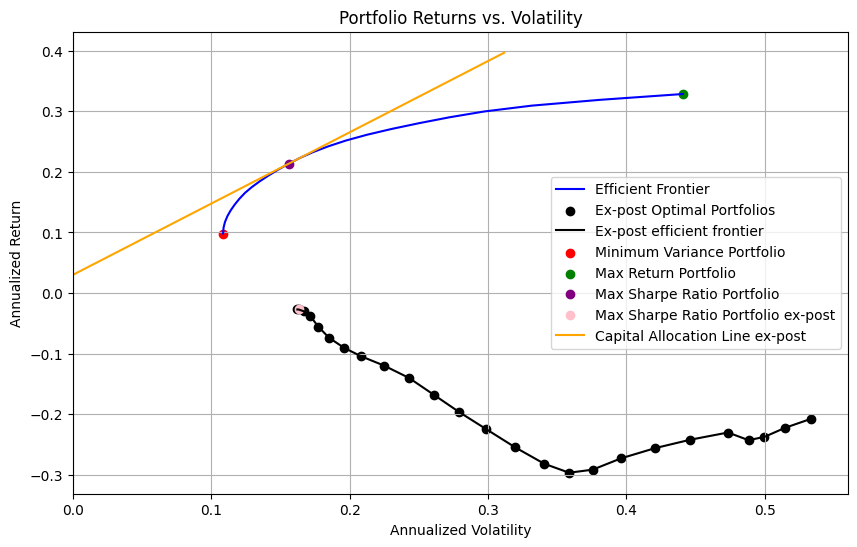

In [1645]:
#Find the index of the maximum value in the 'Ex-post Sharpe Ratio' column of the dataFrame
max_sharpe_index_expost = df_portfolio_22['Ex-post Sharpe Ratio'].idxmax()

#Get the ex-post volatility and the ex-post return of the maximum ex-post sharpe ratio portfolio
max_sharpe_volatility_expost = df_portfolio_22.loc[max_sharpe_index_expost, 'Ex-post Annualized Volatility']
max_sharpe_return_expost = df_portfolio_22.loc[max_sharpe_index_expost, 'Ex-post Annualized Returns']

#Define the boundaries of the ex-post CAL
CAL_x_expost = max_sharpe_volatility_expost * 1.2
CAL_y_expost = rfr_expected + (CAL_x_expost * (max_sharpe_return_expost - rfr_expected) / max_sharpe_volatility_expost)

#Plot the figure
#Initialize the figure
plt.figure(figsize=(10, 6))

#Plot the efficient frontier ex-ante
#plt.scatter(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Optimal Portfolios')
plt.plot(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Efficient Frontier')

#Plot the efficient frontier ex-post
plt.scatter(df_portfolio_22['Ex-post Annualized Volatility'], df_portfolio_22['Ex-post Annualized Returns'], color='black', label='Ex-post Optimal Portfolios')
plt.plot(df_portfolio_22['Ex-post Annualized Volatility'], df_portfolio_22['Ex-post Annualized Returns'], color='black', label='Ex-post efficient frontier')

#Plot the MVP, MaxRP, Max Sharpe Ratio Portfolio (ex-ante), Max Sharpe Ratio Portfolio ex-post
plt.scatter(df_frontier_high.loc[MVP_index, 'Annualized Volatility'], df_frontier_high.loc[MVP_index, 'Annualized Return'], color='red', label='Minimum Variance Portfolio')
plt.scatter(df_frontier_high.loc[MaxRP_index, 'Annualized Volatility'], df_frontier_high.loc[MaxRP_index, 'Annualized Return'], color='green', label='Max Return Portfolio')
plt.scatter(df_frontier_high.loc[max_sharpe_index, 'Annualized Volatility'], df_frontier_high.loc[max_sharpe_index, 'Annualized Return'], color='purple', label='Max Sharpe Ratio Portfolio')
plt.scatter(max_sharpe_volatility_expost, max_sharpe_return_expost, color='pink', label='Max Sharpe Ratio Portfolio ex-post')

#Plot the ex-post CAL
plt.plot([0, CAL_x], [rfr_expected, CAL_y], color='orange', label='Capital Allocation Line ex-post')

#Add title, legends, ect
plt.xlim(0)
plt.title('Portfolio Returns vs. Volatility')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

### Ex-ante assets

In [1686]:
df_M_returns_E

NAME,FLUGHAFEN WIEN,ERSTE GROUP BANK,OMV,VERBUND,WIENERBERGER,VIENNA INSURANCE GROUP A,VOESTALPINE,MAYR-MELNHOF KARTON,IMMOFINANZ,SOLVAY,...,HOLMEN B,FABEGE,KINNEVIK B,INVESTOR A,SWEDISH MATCH DEAD - DELIST.02/01/23,HEXAGON B,ELECTROLUX B,ATLAS COPCO A,MODERN TIMES GROUP MTG B,BOLIDEN ORD SHS
2007-02-28,-0.068733,-0.043525,0.044308,-0.128370,0.000236,-0.045084,0.071533,0.004315,0.002618,-0.064098,...,-0.061145,-0.001679,-0.011071,-0.054552,-0.023143,-0.071658,0.185578,-0.078060,-0.124549,-0.090237
2007-03-31,0.054181,0.046109,0.126189,0.087085,0.013138,0.016336,0.169212,0.148572,0.052460,0.078100,...,0.047134,0.060810,0.111434,0.051096,0.031038,0.067845,0.127457,0.052216,0.054330,0.040650
2007-04-30,0.117565,0.037929,0.017653,0.158154,0.164524,0.064849,-0.060644,0.058167,0.021837,0.038186,...,0.094971,0.072692,0.036187,0.145635,0.065194,0.132583,0.062757,0.185050,0.009974,0.151563
2007-05-31,-0.080157,-0.026086,0.061920,0.040032,0.066878,-0.003339,0.069365,-0.003570,-0.010755,0.015520,...,-0.019841,-0.034906,-0.015122,-0.034976,-0.002258,0.250901,-0.040551,0.027658,0.053345,-0.086839
2007-06-30,0.012280,0.005986,0.006952,-0.049264,-0.021353,-0.035212,0.162549,-0.014881,-0.095842,-0.011786,...,-0.036711,-0.149623,0.017547,-0.006174,0.043493,0.027450,-0.055661,-0.002777,0.064430,0.002972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,-0.000959,0.030485,0.026322,0.186019,-0.039756,0.051139,0.028155,-0.008952,0.073706,-0.018228,...,-0.035453,0.044056,-0.103205,-0.036580,0.029597,0.044925,-0.035759,0.013797,0.002514,-0.106557
2021-09-30,0.046423,0.103558,0.091615,-0.071672,-0.139315,-0.004208,-0.180824,-0.092977,-0.061964,-0.047418,...,-0.130560,-0.152429,-0.097111,-0.092510,-0.049987,-0.102058,-0.068324,-0.112905,-0.145793,-0.073673
2021-10-31,-0.049826,-0.026671,0.002726,0.025842,0.049231,0.012553,0.023450,0.029982,0.040962,-0.046469,...,0.004657,0.116286,0.109249,0.062973,0.004282,0.033998,0.072046,0.063067,-0.058913,0.093037
2021-11-30,-0.075124,0.037405,-0.128138,-0.001438,0.032372,-0.056249,-0.115016,-0.019345,-0.037717,-0.064059,...,0.006313,-0.015453,-0.092941,0.043278,-0.175294,-0.094731,-0.016676,-0.048094,-0.132548,-0.026634


In [1687]:
df_Assets_ret_vol = pd.DataFrame()

In [1688]:
df_M_returns_E.mean().tolist()

[0.007858421783137618,
 0.00862564320166679,
 0.008981462331400196,
 0.011713304745927067,
 0.006840497491721605,
 0.002048042684603325,
 0.006818692112816325,
 0.008234433076073829,
 0.006833757230600122,
 0.005132374519493852,
 0.010186617100334708,
 0.004196813064614714,
 0.011894043920415726,
 -0.00048087651797169194,
 0.007846772625563528,
 0.0003022312565818707,
 0.003912026064846706,
 0.009357027749556992,
 0.004734693140467268,
 0.011283321070325973,
 0.0026961554112294984,
 0.007465277867995353,
 0.01218211656739106,
 0.010016538767921305,
 0.007405656865665192,
 0.008754736981333715,
 -0.003501043137554638,
 0.005113077225251562,
 0.00919139431076954,
 0.003301425099951671,
 0.010089785568767325,
 0.00712029861084537,
 -0.004445734027592411,
 0.009204320187028481,
 0.014131207466221908,
 0.017665741672796487,
 0.003884465533521184,
 0.013020593602432923,
 0.01174819829852936,
 0.013313626444144584,
 0.013976938191508293,
 0.013410262203290972,
 0.009405239917785156,
 0.011055

In [1691]:
df_Assets_ret_vol['FIRMS'] = df_M_returns_22_E.columns.tolist()
df_Assets_ret_vol['Returns'] = df_M_returns_22_E.mean().tolist()
df_Assets_ret_vol['Returns'] = df_assets_ret_vol['Returns'] *12
df_Assets_ret_vol['Volatility'] = df_M_returns_22_E.std().tolist()

In [1692]:
df_Assets_ret_vol

,FIRMS,Returns,Volatility
0,FLUGHAFEN WIEN,1.898219,0.070936
1,ERSTE GROUP BANK,-2.821636,0.130134
2,OMV,0.525698,0.134169
3,VERBUND,-2.675198,0.101791
4,WIENERBERGER,-3.775928,0.112091
...,...,...,...
418,HEXAGON B,-4.152495,0.098745
419,ELECTROLUX B,-5.188675,0.113413
420,ATLAS COPCO A,-2.986375,0.130516
421,MODERN TIMES GROUP MTG B,3.560380,0.187505


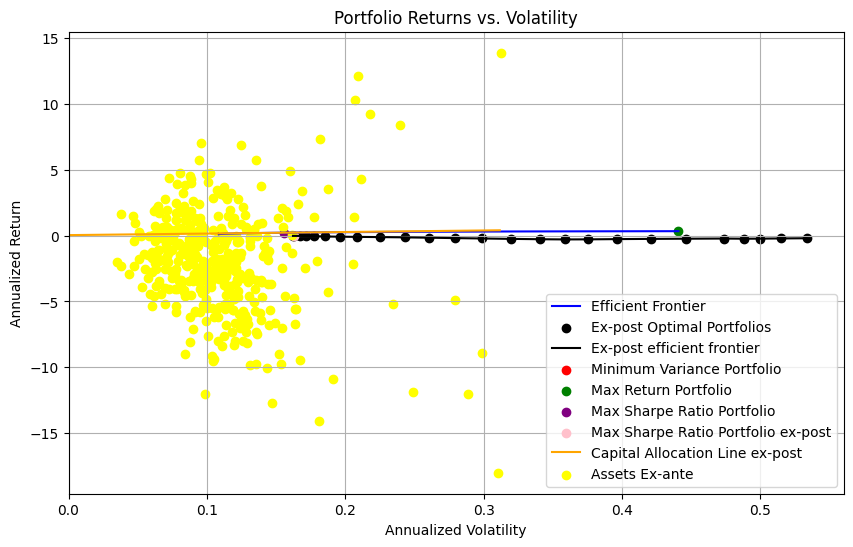

In [1693]:
#Find the index of the maximum value in the 'Ex-post Sharpe Ratio' column of the dataFrame
max_sharpe_index_expost = df_portfolio_22['Ex-post Sharpe Ratio'].idxmax()

#Get the ex-post volatility and the ex-post return of the maximum ex-post sharpe ratio portfolio
max_sharpe_volatility_expost = df_portfolio_22.loc[max_sharpe_index_expost, 'Ex-post Annualized Volatility']
max_sharpe_return_expost = df_portfolio_22.loc[max_sharpe_index_expost, 'Ex-post Annualized Returns']

#Define the boundaries of the ex-post CAL
CAL_x_expost = max_sharpe_volatility_expost * 1.2
CAL_y_expost = rfr_expected + (CAL_x_expost * (max_sharpe_return_expost - rfr_expected) / max_sharpe_volatility_expost)

#Plot the figure
#Initialize the figure
plt.figure(figsize=(10, 6))

#Plot the efficient frontier ex-ante
#plt.scatter(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Optimal Portfolios')
plt.plot(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Efficient Frontier')

#Plot the efficient frontier ex-post
plt.scatter(df_portfolio_22['Ex-post Annualized Volatility'], df_portfolio_22['Ex-post Annualized Returns'], color='black', label='Ex-post Optimal Portfolios')
plt.plot(df_portfolio_22['Ex-post Annualized Volatility'], df_portfolio_22['Ex-post Annualized Returns'], color='black', label='Ex-post efficient frontier')

#Plot the MVP, MaxRP, Max Sharpe Ratio Portfolio (ex-ante), Max Sharpe Ratio Portfolio ex-post
plt.scatter(df_frontier_high.loc[MVP_index, 'Annualized Volatility'], df_frontier_high.loc[MVP_index, 'Annualized Return'], color='red', label='Minimum Variance Portfolio')
plt.scatter(df_frontier_high.loc[MaxRP_index, 'Annualized Volatility'], df_frontier_high.loc[MaxRP_index, 'Annualized Return'], color='green', label='Max Return Portfolio')
plt.scatter(df_frontier_high.loc[max_sharpe_index, 'Annualized Volatility'], df_frontier_high.loc[max_sharpe_index, 'Annualized Return'], color='purple', label='Max Sharpe Ratio Portfolio')
plt.scatter(max_sharpe_volatility_expost, max_sharpe_return_expost, color='pink', label='Max Sharpe Ratio Portfolio ex-post')

#Plot the ex-post CAL
plt.plot([0, CAL_x], [rfr_expected, CAL_y], color='orange', label='Capital Allocation Line ex-post')

#Plot the assets ex-post
plt.scatter(df_Assets_ret_vol['Volatility'], df_Assets_ret_vol['Returns'], color='yellow', label='Assets Ex-ante')

#Add title, legends, ect
plt.xlim(0)
plt.title('Portfolio Returns vs. Volatility')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

### Ex-post assets

In [1655]:
df_M_returns_22_E

NAME,FLUGHAFEN WIEN,ERSTE GROUP BANK,OMV,VERBUND,WIENERBERGER,VIENNA INSURANCE GROUP A,VOESTALPINE,MAYR-MELNHOF KARTON,IMMOFINANZ,SOLVAY,...,HOLMEN B,FABEGE,KINNEVIK B,INVESTOR A,SWEDISH MATCH DEAD - DELIST.02/01/23,HEXAGON B,ELECTROLUX B,ATLAS COPCO A,MODERN TIMES GROUP MTG B,BOLIDEN ORD SHS
2022-01-31,0.045070,-0.017086,0.064909,-0.065063,-0.025202,0.027346,-0.093706,-0.038791,0.006766,0.037394,...,0.000546,-0.115790,-0.172933,-0.145478,-0.032722,-0.161358,-0.154198,-0.158052,0.299695,0.035070
2022-02-28,-0.005181,-0.222612,-0.213086,0.153609,-0.160986,-0.096533,0.002616,-0.019011,0.000145,-0.061855,...,0.031310,0.016525,-0.126390,-0.006801,-0.045179,0.025195,-0.117735,-0.099883,-0.021452,0.121249
2022-03-31,-0.071303,0.024673,0.014220,-0.124043,0.013548,-0.007269,-0.090822,-0.051694,-0.009392,-0.111310,...,0.167176,0.002185,0.031085,0.057366,0.035235,0.044213,-0.123966,0.007219,0.138457,0.143320
2022-04-30,-0.026577,-0.150132,0.072910,0.014660,-0.065702,-0.043776,-0.120637,-0.010740,-0.053461,-0.040202,...,0.034607,-0.180403,-0.249859,-0.105387,0.068660,-0.078859,0.005736,-0.118020,-0.276448,-0.120823
2022-05-31,-0.009072,0.046917,0.125019,-0.069705,-0.003308,0.014826,0.105362,-0.017804,-0.098783,0.039523,...,-0.125051,0.045561,-0.000300,-0.000506,0.284345,-0.065268,0.003241,-0.013003,0.099450,-0.008160
2022-06-30,0.215260,-0.185894,-0.159157,-0.016706,-0.222906,-0.050209,-0.274492,-0.008163,-0.305917,-0.171700,...,-0.209650,-0.257652,-0.192491,-0.139228,-0.014032,-0.146831,-0.132928,-0.165492,-0.101333,-0.241827
2022-07-31,-0.023149,-0.004502,-0.097421,0.123206,0.068705,0.002197,0.119471,-0.061965,0.007021,0.078548,...,0.007548,0.080770,0.109712,0.138937,0.024411,0.125264,0.065140,0.241231,0.282225,0.041119
2022-08-31,-0.010844,-0.102476,-0.040985,-0.125302,0.025707,0.041194,-0.093996,-0.056886,-0.023731,-0.069899,...,0.057246,-0.127134,-0.196640,-0.180800,-0.033070,-0.117770,-0.111130,-0.116587,-0.143647,-0.022490
2022-09-30,-0.021276,-0.018766,-0.096105,-0.106440,-0.140093,-0.139022,-0.152104,-0.136879,-0.178549,-0.037799,...,-0.113088,-0.220618,-0.072336,-0.075520,-0.015891,-0.083422,-0.143574,-0.076555,-0.243420,-0.033389
2022-10-31,0.007311,0.112197,0.259085,-0.085763,0.133224,0.093316,0.266377,0.100553,-0.034777,0.155775,...,-0.052283,0.060867,-0.071262,0.099971,0.037126,0.047419,0.177424,0.140971,0.123786,-0.068215


In [1652]:
df_assets_ret_vol = pd.DataFrame() 

In [1673]:
df_M_returns_22_E.mean().tolist()

[0.013182078766785501,
 -0.019594694843020465,
 0.0036506777772245536,
 -0.01857776667836915,
 -0.02622171999158694,
 -0.007778749524676822,
 -0.009336220741257978,
 -0.013491669360508274,
 -0.053188543224793106,
 -0.005551303464432611,
 -0.011287559781715787,
 -0.04053682422848225,
 -0.05642880667704033,
 -0.016048828614345867,
 -0.02494765019087451,
 -0.03195889595649973,
 -0.023972066285234035,
 -0.00047941978287801185,
 -0.0042032502728185555,
 -0.0013101829988590812,
 -0.030753367665478232,
 0.0019654356664888426,
 -0.018544048232058453,
 0.012836190824894261,
 0.00655750762660499,
 -0.020211262892031012,
 -0.08338256997509991,
 -0.028082633282433406,
 -0.01919275765698968,
 0.007931557300831837,
 -0.010761615635365837,
 -0.0006772841096688298,
 -0.032002165280043765,
 0.0005079173288425979,
 -0.032642290562431155,
 -0.038292885968574,
 0.011553279685123688,
 -0.0076275003330187234,
 -0.02824034011560561,
 -0.020008082268761485,
 -0.019838656052267378,
 -0.04030230515571782,
 -0.0

In [1683]:
df_assets_ret_vol['FIRMS'] = df_M_returns_22_E.columns.tolist()
df_assets_ret_vol['Returns'] = df_M_returns_22_E.mean().tolist()
df_assets_ret_vol['Returns'] = df_assets_ret_vol['Returns'] *12
df_assets_ret_vol['Volatility'] = df_M_returns_22_E.std().tolist()

In [1684]:
df_assets_ret_vol

,FIRMS,RETURNS,VOLATILITIES,Returns,Volatility
0,FLUGHAFEN WIEN,0.158185,0.070936,0.158185,0.070936
1,ERSTE GROUP BANK,-0.235136,0.130134,-0.235136,0.130134
2,OMV,0.043808,0.134169,0.043808,0.134169
3,VERBUND,-0.222933,0.101791,-0.222933,0.101791
4,WIENERBERGER,-0.314661,0.112091,-0.314661,0.112091
...,...,...,...,...,...
418,HEXAGON B,-0.346041,0.098745,-0.346041,0.098745
419,ELECTROLUX B,-0.432390,0.113413,-0.432390,0.113413
420,ATLAS COPCO A,-0.248865,0.130516,-0.248865,0.130516
421,MODERN TIMES GROUP MTG B,0.296698,0.187505,0.296698,0.187505


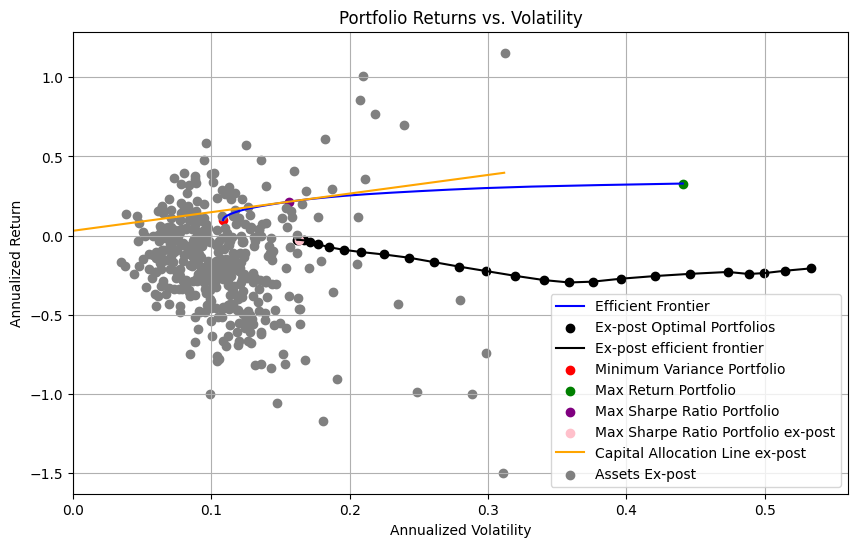

In [1685]:
#Find the index of the maximum value in the 'Ex-post Sharpe Ratio' column of the dataFrame
max_sharpe_index_expost = df_portfolio_22['Ex-post Sharpe Ratio'].idxmax()

#Get the ex-post volatility and the ex-post return of the maximum ex-post sharpe ratio portfolio
max_sharpe_volatility_expost = df_portfolio_22.loc[max_sharpe_index_expost, 'Ex-post Annualized Volatility']
max_sharpe_return_expost = df_portfolio_22.loc[max_sharpe_index_expost, 'Ex-post Annualized Returns']

#Define the boundaries of the ex-post CAL
CAL_x_expost = max_sharpe_volatility_expost * 1.2
CAL_y_expost = rfr_expected + (CAL_x_expost * (max_sharpe_return_expost - rfr_expected) / max_sharpe_volatility_expost)

#Plot the figure
#Initialize the figure
plt.figure(figsize=(10, 6))

#Plot the efficient frontier ex-ante
#plt.scatter(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Optimal Portfolios')
plt.plot(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Efficient Frontier')

#Plot the efficient frontier ex-post
plt.scatter(df_portfolio_22['Ex-post Annualized Volatility'], df_portfolio_22['Ex-post Annualized Returns'], color='black', label='Ex-post Optimal Portfolios')
plt.plot(df_portfolio_22['Ex-post Annualized Volatility'], df_portfolio_22['Ex-post Annualized Returns'], color='black', label='Ex-post efficient frontier')

#Plot the MVP, MaxRP, Max Sharpe Ratio Portfolio (ex-ante), Max Sharpe Ratio Portfolio ex-post
plt.scatter(df_frontier_high.loc[MVP_index, 'Annualized Volatility'], df_frontier_high.loc[MVP_index, 'Annualized Return'], color='red', label='Minimum Variance Portfolio')
plt.scatter(df_frontier_high.loc[MaxRP_index, 'Annualized Volatility'], df_frontier_high.loc[MaxRP_index, 'Annualized Return'], color='green', label='Max Return Portfolio')
plt.scatter(df_frontier_high.loc[max_sharpe_index, 'Annualized Volatility'], df_frontier_high.loc[max_sharpe_index, 'Annualized Return'], color='purple', label='Max Sharpe Ratio Portfolio')
plt.scatter(max_sharpe_volatility_expost, max_sharpe_return_expost, color='pink', label='Max Sharpe Ratio Portfolio ex-post')

#Plot the ex-post CAL
plt.plot([0, CAL_x], [rfr_expected, CAL_y], color='orange', label='Capital Allocation Line ex-post')

#Plot the assets ex-post
plt.scatter(df_assets_ret_vol['Volatility'], df_assets_ret_vol['Returns'], color='grey', label='Assets Ex-post')

#Add title, legends, ect
plt.xlim(0)
plt.title('Portfolio Returns vs. Volatility')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

### Equally weighted and value weighted portfolios

NameError: name 'portfolio_vol_EW' is not defined

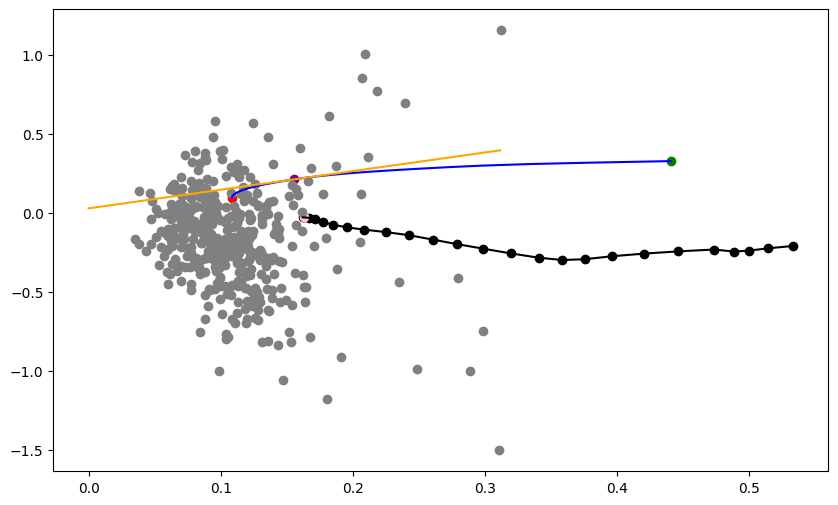

In [1696]:
#Find the index of the maximum value in the 'Ex-post Sharpe Ratio' column of the dataFrame
max_sharpe_index_expost = df_portfolio_22['Ex-post Sharpe Ratio'].idxmax()

#Get the ex-post volatility and the ex-post return of the maximum ex-post sharpe ratio portfolio
max_sharpe_volatility_expost = df_portfolio_22.loc[max_sharpe_index_expost, 'Ex-post Annualized Volatility']
max_sharpe_return_expost = df_portfolio_22.loc[max_sharpe_index_expost, 'Ex-post Annualized Returns']

#Define the boundaries of the ex-post CAL
CAL_x_expost = max_sharpe_volatility_expost * 1.2
CAL_y_expost = rfr_expected + (CAL_x_expost * (max_sharpe_return_expost - rfr_expected) / max_sharpe_volatility_expost)

#Plot the figure
#Initialize the figure
plt.figure(figsize=(10, 6))

#Plot the efficient frontier ex-ante
#plt.scatter(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Optimal Portfolios')
plt.plot(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Efficient Frontier')

#Plot the efficient frontier ex-post
plt.scatter(df_portfolio_22['Ex-post Annualized Volatility'], df_portfolio_22['Ex-post Annualized Returns'], color='black', label='Ex-post Optimal Portfolios')
plt.plot(df_portfolio_22['Ex-post Annualized Volatility'], df_portfolio_22['Ex-post Annualized Returns'], color='black', label='Ex-post efficient frontier')

#Plot the MVP, MaxRP, Max Sharpe Ratio Portfolio (ex-ante), Max Sharpe Ratio Portfolio ex-post
plt.scatter(df_frontier_high.loc[MVP_index, 'Annualized Volatility'], df_frontier_high.loc[MVP_index, 'Annualized Return'], color='red', label='Minimum Variance Portfolio')
plt.scatter(df_frontier_high.loc[MaxRP_index, 'Annualized Volatility'], df_frontier_high.loc[MaxRP_index, 'Annualized Return'], color='green', label='Max Return Portfolio')
plt.scatter(df_frontier_high.loc[max_sharpe_index, 'Annualized Volatility'], df_frontier_high.loc[max_sharpe_index, 'Annualized Return'], color='purple', label='Max Sharpe Ratio Portfolio')
plt.scatter(max_sharpe_volatility_expost, max_sharpe_return_expost, color='pink', label='Max Sharpe Ratio Portfolio ex-post')

#Plot the ex-post CAL
plt.plot([0, CAL_x], [rfr_expected, CAL_y], color='orange', label='Capital Allocation Line ex-post')

#Plot the assets ex-post
plt.scatter(df_assets_ret_vol['Volatility'], df_assets_ret_vol['Returns'], color='grey', label='Assets Ex-post')

#Plot the Equally weighted and Value weighted portfolios
plt.scatter(portfolio_vol_EW, EW_returns_avrg_ann, marker='x', color='brown', label='Equally weighted Portfolio')
plt.scatter(portfolio_vol_VW, VW_returns_avrg_ann, marker='x', color='lightblue', label='Value weighted Portfolio')

#Add title, legends, ect
plt.xlim(0)
plt.title('Portfolio Returns vs. Volatility')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
VW_returns_avrg_ann
portfolio_vol_VW
EW_returns_avrg_ann
portfolio_vol_EW